Data loading

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving D&O.csv to D&O.csv


Load libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import io

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['D&O.csv']), index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-28,0.390,0.495,0.390,0.46,0.425383,77841700.0
2004-12-29,0.465,0.510,0.460,0.50,0.462373,19786600.0
2004-12-30,0.500,0.510,0.475,0.48,0.443878,6846700.0
2004-12-31,0.485,0.510,0.480,0.49,0.453125,8420300.0
2005-01-03,0.500,0.520,0.485,0.51,0.471620,7385000.0
...,...,...,...,...,...,...
2021-05-19,4.350,4.420,4.040,4.11,4.110000,12099800.0
2021-05-20,4.190,4.330,4.000,4.04,4.040000,9428200.0
2021-05-21,4.140,4.290,3.920,4.20,4.200000,9529800.0


Plotting the dataset

No handles with labels found to put in legend.


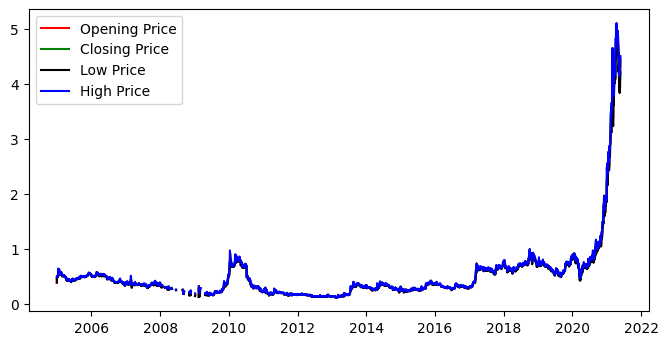

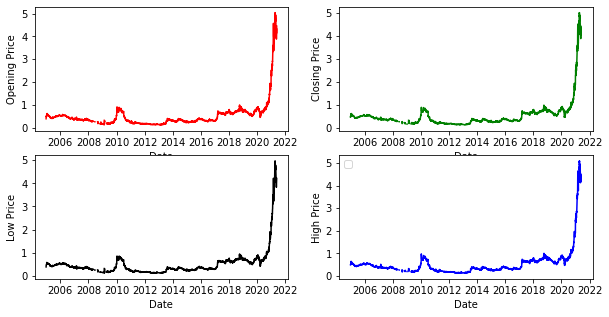

In [ ]:
plt.figure(figsize=(8, 4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(df['Open'], color='red', label = 'Opening Price')
plt.plot(df['Close'], color='green', label = 'Closing Price')
plt.plot(df['Low'], color='black', label = 'Low Price')
plt.plot(df['High'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (10, 5))

ax1 = plt.subplot(2, 2, 1)
plt.plot(df['Open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(df['Close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(df['Low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(df['High'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

We choose High and Volume as two attributes to consider in our model and remove some null values.

In [ ]:
df = df.drop(['Open', 'Low', 'Close', 'Adj Close'], axis=1)
df = df.dropna()

Feature Scaling

In [ ]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = minMaxScaler.fit_transform(df)

In [ ]:
df_scaled.shape

(3768, 2)

### GRU

In [ ]:
def CreateData(df, future, past, train_test_split_percentage, validation_split_percentage):
  feature = df.shape[1]
  x_data, y_data = [], []

  for i in range(past, len(df) - future + 1):
    x_data.append(df[i - past:i, 0:feature])
    y_data.append(df[i + future - 1:i + future, 0])

  split_training_test_starting_point = int(round(train_test_split_percentage * len(x_data)))
  split_train_validation_starting_point = int(round(split_training_test_starting_point * (1 - validation_split_percentage)))

  X_train = x_data[:split_train_validation_starting_point]
  y_train = y_data[:split_train_validation_starting_point]

  X_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
  y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]

  X_test = x_data[split_training_test_starting_point:]
  y_test = y_data[split_training_test_starting_point:]

  return np.array(X_train), np.array(X_test), np.array(X_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = CreateData(df_scaled, future=1, past=25, train_test_split_percentage=0.8, validation_split_percentage = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2994, 25, 2)
(749, 25, 2)
(2994, 1)
(749, 1)


GRU Training

In [ ]:
regressor = Sequential()

regressor.add(GRU(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(GRU(units=256, return_sequences=False))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=500, batch_size=64, callbacks=[early_stopping])

Epoch 1/500
33/33 [==============================] - 29s 279ms/step - loss: 9.7520e-04 - val_loss: 6.3800e-05
Epoch 2/500
33/33 [==============================] - 8s 248ms/step - loss: 3.1497e-05 - val_loss: 3.7696e-05
Epoch 3/500
33/33 [==============================] - 8s 242ms/step - loss: 2.0449e-05 - val_loss: 1.6363e-05
Epoch 4/500
33/33 [==============================] - 8s 245ms/step - loss: 1.8046e-05 - val_loss: 2.4656e-05
Epoch 5/500
33/33 [==============================] - 8s 245ms/step - loss: 2.0403e-05 - val_loss: 2.1683e-05
Epoch 6/500
33/33 [==============================] - 8s 249ms/step - loss: 1.7407e-05 - val_loss: 2.4405e-05
Epoch 7/500
33/33 [==============================] - 8s 246ms/step - loss: 1.6506e-05 - val_loss: 2.2000e-05
Epoch 8/500
33/33 [==============================] - 8s 249ms/step - loss: 2.7435e-05 - val_loss: 3.1015e-05
Epoch 9/500
33/33 [==============================] - 8s 247ms/step - loss: 2.2041e-05 - val_loss: 3.3505e-05
Epoch 10/500
33/33

#### Hyperparameter tuning

In [ ]:
def LSTM_Hyperparameter_Tuning(config, X_train, y_train, X_test, y_test):
  first_additional_layer, second_additional_layer, third_additional_layer, neurons, batch_size, dropout = config
  possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer, neurons, batch_size, dropout))

  print(f'Possible combinations: \n{possible_combinations}\n')

  hist = []

  for i in range(0, len(possible_combinations)):
    print(f'{i}th combination: \n')
    print('--------------------------------------------------------------------')

    first_additional_layer, second_additional_layer, third_additional_layer, neurons, batch_size, dropout = possible_combinations[i]

    regressor = Sequential()
    regressor.add(GRU(units=neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(dropout))

    if first_additional_layer:
      regressor.add(GRU(units=neurons, return_sequences=True))
      regressor.add(Dropout(dropout))

    if second_additional_layer:
      regressor.add(GRU(units=neurons, return_sequences=True))
      regressor.add(Dropout(dropout))

    if third_additional_layer:
      regressor.add(GRU(units=neurons, return_sequences=True))
      regressor.add(Dropout(dropout))

    regressor.add(GRU(units=neurons, return_sequences=False))
    regressor.add(Dropout(dropout))
    regressor.add(Dense(units=1, activation='linear'))
    regressor.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
    file_path = 'best_model.h5'
    model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    regressor.fit(X_train, y_train, validation_split=0.3, epochs=500, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

    train_accuracy = regressor.evaluate(X_train, y_train, verbose=0)
    test_accuracy = regressor.evaluate(X_test, y_test, verbose=0)

    hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, neurons, batch_size, dropout, train_accuracy, test_accuracy)))
    print(f'{str(i)}-th combination = {possible_combinations[i]} \n Train accuracy: {train_accuracy} and Test accuracy: {test_accuracy}')

    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')

  return hist

In [ ]:
config = [[False, True], [False, True], [False, True], [128, 256], [32, 64, 128], [0.1, 0.2, 0.3]]  
hist = LSTM_Hyperparameter_Tuning(config, X_train, y_train, X_test, y_test)

Streaming output truncated to the last 5000 lines.
Epoch 00381: val_loss did not improve from 0.00001

Epoch 00382: val_loss did not improve from 0.00001

Epoch 00383: val_loss did not improve from 0.00001

Epoch 00384: val_loss did not improve from 0.00001

Epoch 00385: val_loss did not improve from 0.00001

Epoch 00386: val_loss did not improve from 0.00001

Epoch 00387: val_loss did not improve from 0.00001

Epoch 00388: val_loss did not improve from 0.00001

Epoch 00389: val_loss did not improve from 0.00001

Epoch 00390: val_loss did not improve from 0.00001

Epoch 00391: val_loss did not improve from 0.00001

Epoch 00392: val_loss did not improve from 0.00001

Epoch 00393: val_loss did not improve from 0.00001

Epoch 00394: val_loss did not improve from 0.00001

Epoch 00395: val_loss did not improve from 0.00001

Epoch 00396: val_loss did not improve from 0.00001

Epoch 00397: val_loss did not improve from 0.00001

Epoch 00398: val_loss did not improve from 0.00001

Epoch 00399: 

Displaying history

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

Results

In [ ]:
print('Best Combination: \n')
print(f'first_additional_layer = {hist.iloc[0, 0]}\n')
print(f'second_additional_layer = {hist.iloc[0, 1]}\n')
print(f'third_additional_layer = {hist.iloc[0, 2]}\n')
print(f'neurons = {hist.iloc[0, 3]}\n')
print(f'batch_size = {hist.iloc[0, 4]}\n')
print(f'dropout  = {hist.iloc[0, 5]}\n')

In [ ]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

In [ ]:
regressor = Sequential()
regressor.add(GRU(units=neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(GRU(units=neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(GRU(units=neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(GRU(units=neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
file_path = 'best_model.h5'
model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
regressor.fit(X_train, y_train, validation_split=0.3, epochs=500, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

In [ ]:
regressor.evaluate(X_test, y_test)

In [ ]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real Opening Price')
plt.plot(y_pred, color='green', label = 'Predicted Opening Price')
plt.legend(loc='best')